In [48]:
%matplotlib inline
import IPython.display as ipd
from ipywidgets import interact, interactive, fixed

import os
import audioop
import pyaudio
import wave
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import copy
from scipy.signal import butter, lfilter
import scipy.ndimage
import librosa
import librosa.display
import random

class AudioFile:
    chunk = 2048
    FORMAT = pyaudio.paInt16
    CHANNELS = 2
    RATE = 44100
    length_capture = 20  #20 ms
    overlap_frame = 4    #4 ms
    start_at = 7         #maybe not used
    end_at = 100
    DEBUG = True

    def __init__(self, file):
        self.file = file

    def play(self):
        self.wf = wave.open(self.file, 'rb')

        # instantiate PyAudio (1)
        self.p = pyaudio.PyAudio()

        # open stream (2)
        self.stream = self.p.open(format=self.p.get_format_from_width(self.wf.getsampwidth()),
                channels=self.wf.getnchannels(),
                rate=self.wf.getframerate(),
                output=True)

        # read data
        self.data = self.wf.readframes(self.chunk)

        # play stream (3)
        while len(self.data) > 0:
            self.stream.write(self.data)
            self.data = self.wf.readframes(self.chunk)

        # stop stream (4)
        self.stream.stop_stream()
        self.stream.close()

        # close PyAudio (5)
        self.p.terminate()

    def record(self, length=3, thres=600):
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Recording")
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            if rms >= thres:
                self.frames.append(data)
           
                
        print("finished recording")
 
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        
        self.wf = wave.open(self.file, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close() 
        
    def plot(self,bgn,lst):
        # read audio samples
        input_data = read(self.file)
        audio = input_data[1]
        
        #put to normalize
        audio = audio / (2.**(16-1))  # normalize

        plt.plot(audio[bgn:lst])
        # label the axes
        plt.ylabel("Amplitude")
        plt.xlabel("Time")
        # set the title  
        plt.title("Recorded Wav")
        # display the plot
        plt.show()
        # Usage example for pyaudio

    def libplot(self):
        wave, sr = librosa.load(self.file, mono=True)
        plt.figure(figsize=(12,4))
        librosa.display.waveplot(wave, sr=sr)
        
    def libspec(self):
        wave, sr = librosa.load(self.file, mono=True)
        D = librosa.stft(wave,hop_length=64)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max),
            y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        
    def aufile(self):
        return self.file
    
    def stagrec(self, fnm=file, length=3, thres=600):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []
        self.temp_frames = []
        self.captured = []
        self.captured_frame_count = 0
        self.the_overlap=[]

        print("Recording")
        
        
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            if rms >= thres:
                
                
                
                self.frames.append(data)
            
                
        print("finished recording")
        #print(len(self.frames))
        #print(len(self.frames[1]))
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        
        for i in range(len(self.frames)):
            self.fnm=self.file
            self.fn = self.fnm.split('.wav')[0]
            print(self.fn)
            self.fn = self.fn + str(i)+'-f.wav'
            
            self.wf = wave.open(self.fn, 'wb')
            self.wf.setnchannels(self.CHANNELS)
            self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
            self.wf.setframerate(self.RATE)
            self.wf.writeframes(b''.join([self.frames[i]]))
            self.wf.close()        

C:\Anaconda3\envs\tensorflow\lib\site-packages\librosa\core\spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


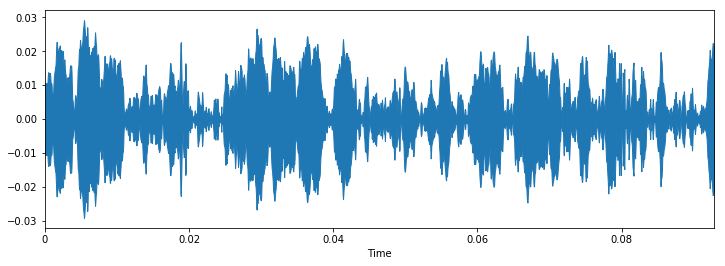

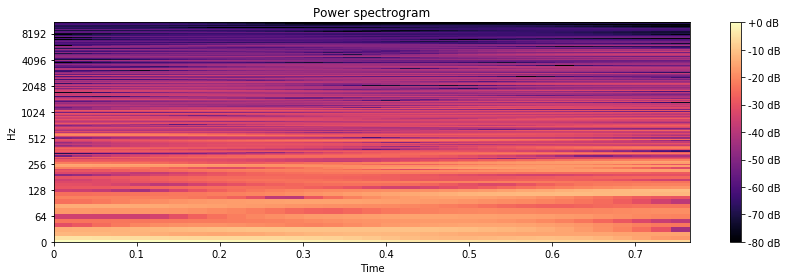

In [49]:
#MAU APA LO??

a = AudioFile("file.wav")
#a.record(5)
a.play()
#a.plot(0,-1)
a.libplot()
a.libspec()

In [12]:
WORD_TO_TRAIN = ['ba','ta','si','mi','nu','ju']
PATH_TO_TRAIN = os.getcwd()+'/data/train'
PATH_TO_TEST = os.getcwd()+'/data/test'
FILE_PREFIX = "irza"
WORKPATH = PATH_TO_TRAIN

In [4]:
#create the dir
for i in WORD_TO_TRAIN:
    try:
        os.mkdir(PATH_TO_TRAIN+"/"+i)
        os.mkdir(PATH_TO_TEST+"/"+i)
    except:
        print("error create dir")

error create dir
error create dir
error create dir
error create dir
error create dir
error create dir


In [50]:
#Generate AUDIO FILE

rann = str(random.randint(0,5000))
print("Sequence:",rann)

#use this for shuffle the word
random.shuffle(WORD_TO_TRAIN)

for i in WORD_TO_TRAIN:
    #gunakan PATH_TO_TEST atau PATH_TO_TRAIN
    file = WORKPATH+"/"+i+"/"+i+"-"+FILE_PREFIX+"-"+rann+".wav"
    a = AudioFile(file)
    print("\nSilahkan baca kalau sudah recording :",i)
    a.stagrec(fnm=file,thres=800)
    
print("\nSelesai proses merekam\n")

Sequence: 4414

Silahkan baca kalau sudah recording : nu
Recording
finished recording
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/nu/nu-irza-4414

Silahkan baca kalau sudah recording : mi
Recording
finished recording
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414
E:\data\python\3.6\RNN-Ayukngaji/data/train/mi/mi-irza-4414

Si

In [39]:
#to replay
for i in WORD_TO_TRAIN:
    #gunakan PATH_TO_TEST atau PATH_TO_TRAIN
    a = AudioFile(WORKPATH+"/"+i+"/"+i+"-"+FILE_PREFIX+"-"+rann+".wav")
    a.play()
    
    

In [30]:
a.stagrec("aw.wav",,thres=800)

TypeError: stagrec() got multiple values for argument 'thres'

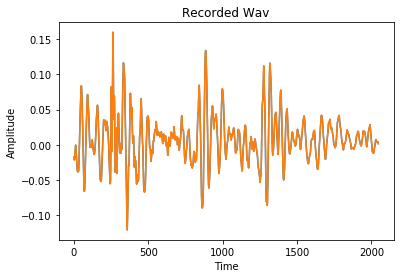

In [85]:
a.plot(0,-1)

In [47]:
a = 'c:\\aa\\aas\\dd\\a-o.wav'
a.split('.wav')[0]

'c:\\aa\\aas\\dd\\a-o'

'E:\\data\\python\\3.6\\RNN-Ayukngaji/data/train/si/si-irza-1771.wav'